In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Базовая работа с изображением

In [16]:
image = cv2.imread('sar_2_color.jpg')

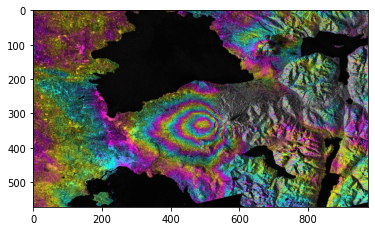

In [17]:
plt.imshow(image)

In [18]:
image.shape # h,w,c

(572, 974, 3)

In [19]:
image[250,250] # b,g,r

array([12, 12, 12], dtype=uint8)

In [20]:
# ROI
img_roi = image[100:200, 500:700]

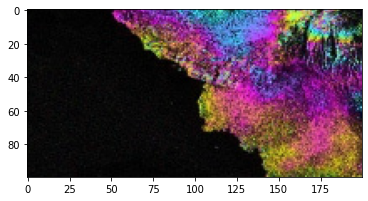

In [21]:
plt.imshow(img_roi)

In [22]:
b,g,r = cv2.split(image)

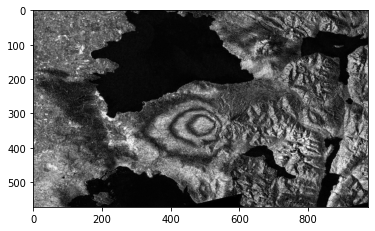

In [23]:
plt.imshow(b, cmap = 'gray')

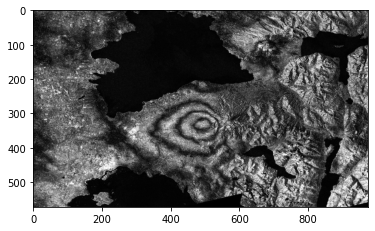

In [24]:
plt.imshow(g, cmap = 'gray')

In [25]:
# alternative approach
b = image[:,:,0]

In [26]:
import copy

image2 = copy.deepcopy(image)

In [27]:
image2[50:100,50:100] = [0,0,0]

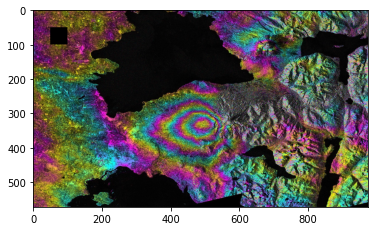

In [28]:
plt.imshow(image2)

In [29]:
# empty image
image_template = np.zeros(image.shape,np.uint8)

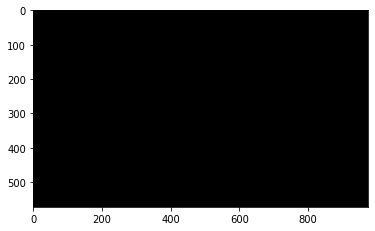

In [30]:
plt.imshow(image_template)

# Конвертация цветовых моделей

In [31]:
image_template[0,0]

array([0, 0, 0], dtype=uint8)

In [32]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

In [33]:
image_gray[0,0]

40

In [34]:
image_gray.shape

(572, 974)

In [35]:
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 

In [36]:
image_hsv.shape

(572, 974, 3)

In [37]:
image_hsv[0,0]

array([117, 143,  75], dtype=uint8)

In [38]:
image[0,0]

array([75, 37, 33], dtype=uint8)

In [39]:
image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

In [40]:
image_lab[0,0]

array([ 42, 139, 104], dtype=uint8)

# Пороговая фильтрация

In [67]:
_,thresh1 = cv2.threshold(image_gray,200,255,cv2.THRESH_BINARY)

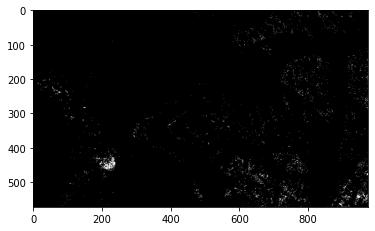

In [68]:
plt.imshow(thresh1, cmap='gray')

In [43]:
thresh1[thresh1==100].sum()

0

# Построение гистограммы

In [44]:
histSize = 256
histRange = (0, 256)
accumulate = False

b_hist = cv2.calcHist([b], [0], None, [histSize], histRange, accumulate=accumulate)

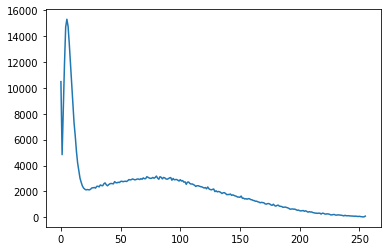

In [45]:
plt.plot(b_hist)

In [46]:
b_hist_cum = b_hist.cumsum()

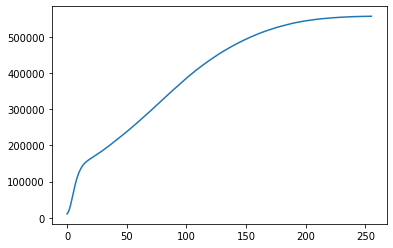

In [47]:
plt.plot(b_hist_cum)

In [49]:
b_hist_norm = b_hist /  (image.shape[0] * image.shape[1])

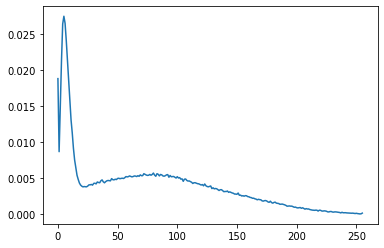

In [50]:
plt.plot(b_hist_norm)

# Сравнение двух изображений

In [53]:
from skimage.metrics import structural_similarity, mean_squared_error

(ssim, diff) = structural_similarity(image_gray, image_gray, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(ssim))

SSIM: 1.0


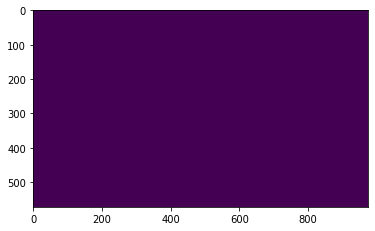

In [54]:
plt.imshow(diff)

In [55]:
mse = mean_squared_error(image_gray, image_gray)
mse

0.0

# Статистические характеристики изображений

In [56]:
mean = image_gray.mean()

In [57]:
std = image_gray.std()

In [58]:
print(mean,std)

67.41225535245043 52.016191875959635


In [60]:
eq_gray = cv2.equalizeHist(image_gray)

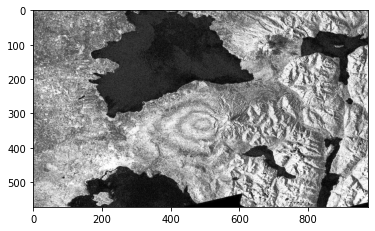

In [63]:
plt.imshow(eq_gray, cmap="gray")


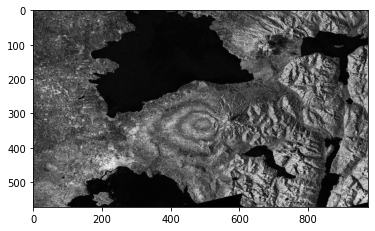

In [64]:
plt.imshow(image_gray, cmap="gray")

In [ ]:
# 1. Загрузите изображение в оттенках серого sar_1_gray.jpg. 
# 2. постройте гистограмму
# 3. реализуйте алгоритм гамма коррекции с параметром гамма <1, >1.
# 4. Сравните исходное изображение, скорректированное при помощи гамма-фильтра. MSE, SSIM.
# 5. реализуйте алгоритм статистической цветокоррекции на основе статистики eq_gray.
# 6. Протестируйте работу алгоритмов пороговой фильтрации с различными параметрами.
# Для каждого решения - напечатайте результат


In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [8]:
# 1) Загрузка изображения в оттенках серого
# ----------------------------------------------------------------
img_path = 'sar_1_gray.jpg'
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
assert gray is not None, "Файл sar_1_gray.jpg не найден или не читается."
H, W = gray.shape
N = H * W

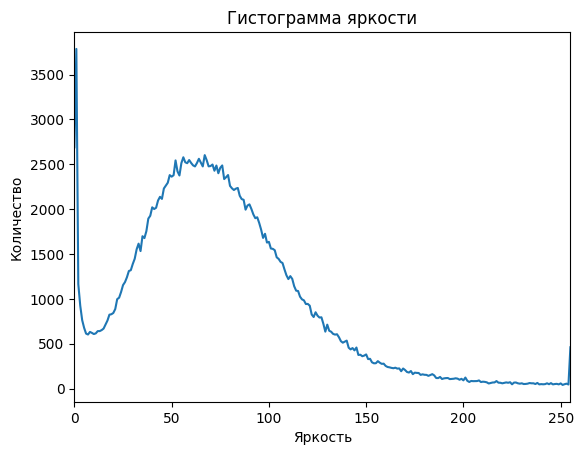

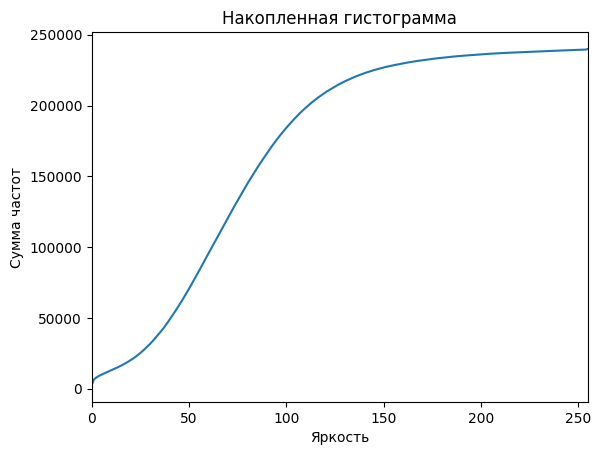

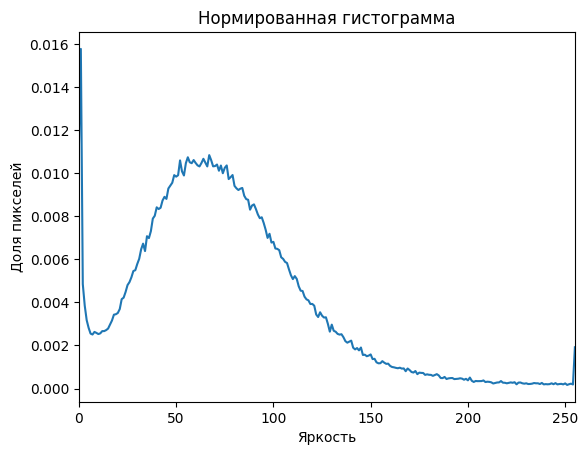

In [9]:
# 2) Гистограммы: обычная, накопленная, нормированная
# ----------------------------------------------------------------
bins = 256
hist, edges = np.histogram(gray.ravel(), bins=bins, range=(0,256))
hist_cum = np.cumsum(hist)
hist_norm = hist / float(N)

plt.figure(); plt.title("Гистограмма яркости")
plt.plot(hist); plt.xlim([0,255]); plt.xlabel("Яркость"); plt.ylabel("Количество"); plt.show()

plt.figure(); plt.title("Накопленная гистограмма")
plt.plot(hist_cum); plt.xlim([0,255]); plt.xlabel("Яркость"); plt.ylabel("Cумма частот"); plt.show()

plt.figure(); plt.title("Нормированная гистограмма")
plt.plot(hist_norm); plt.xlim([0,255]); plt.xlabel("Яркость"); plt.ylabel("Доля пикселей"); plt.show()

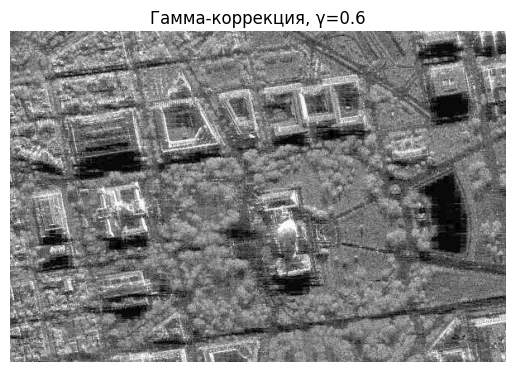

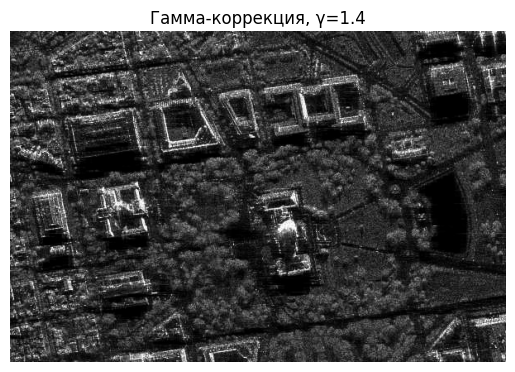

In [10]:
# 3) Гамма-коррекция (gamma < 1 и > 1)
# ----------------------------------------------------------------
gray_f = gray.astype(np.float32) / 255.0

gamma_values = [0.6, 1.4]   # <1 и >1
gamma_images = []
for g in gamma_values:
    corrected = np.power(gray_f, g)
    corrected_u8 = np.clip(corrected * 255.0, 0, 255).astype(np.uint8)
    gamma_images.append(corrected_u8)
    plt.figure(); plt.title(f"Гамма-коррекция, γ={g}")
    plt.imshow(corrected_u8, cmap='gray', vmin=0, vmax=255); plt.axis('off'); plt.show()

In [13]:
# 4) Сравнение: MSE и SSIM (исходное vs gamma-корректированное)
# ----------------------------------------------------------------
for g, im_g in zip(gamma_values, gamma_images):
    mse_val = np.mean((gray.astype(np.float32) - im_g.astype(np.float32))**2)
    ssim_val = ssim(gray, im_g, data_range=255)
    print(f"γ={g}: MSE={mse_val:.2f}, SSIM={ssim_val:.6f}")

[METRICS] γ=0.6: MSE=1784.27, SSIM=0.853523
[METRICS] γ=1.4: MSE=696.04, SSIM=0.863297


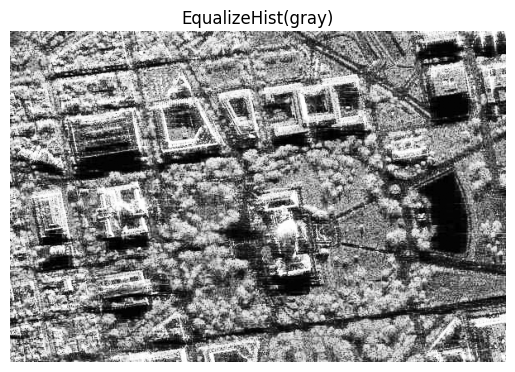

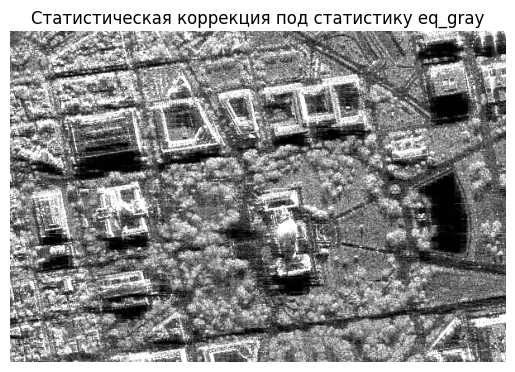

Стат. коррекция vs eq_gray: MSE=247.70, SSIM=0.950007


In [14]:
# 5) Статистическая «цветокоррекция» (на сером) на основе eq_gray
# ----------------------------------------------------------------
eq_gray = cv2.equalizeHist(gray)

plt.figure(); plt.title("EqualizeHist(gray)")
plt.imshow(eq_gray, cmap='gray', vmin=0, vmax=255); plt.axis('off'); plt.show()

mean_src, std_src = gray.mean(), gray.std()
mean_ref, std_ref = eq_gray.mean(), eq_gray.std()
gray_corr = (gray.astype(np.float32) - mean_src) / (std_src + 1e-8) * (std_ref + 1e-8) + mean_ref
gray_corr = np.clip(gray_corr, 0, 255).astype(np.uint8)

plt.figure(); plt.title("Статистическая коррекция под статистику eq_gray")
plt.imshow(gray_corr, cmap='gray', vmin=0, vmax=255); plt.axis('off'); plt.show()

mse_stat = np.mean((eq_gray.astype(np.float32) - gray_corr.astype(np.float32))**2)
ssim_stat = ssim(eq_gray, gray_corr, data_range=255)
print(f"Стат. коррекция vs eq_gray: MSE={mse_stat:.2f}, SSIM={ssim_stat:.6f}")

[THRESH] T= 32 -> white=205184 (85.49%), black=34816 (14.51%)


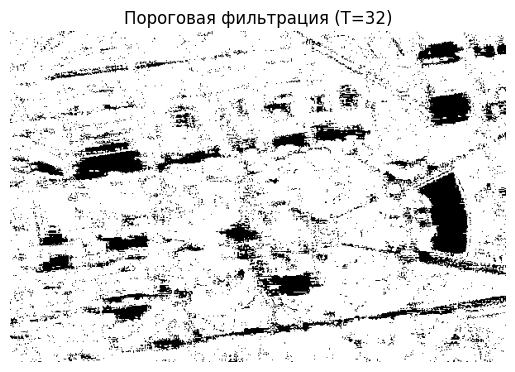

[THRESH] T= 64 -> white=134235 (55.93%), black=105765 (44.07%)


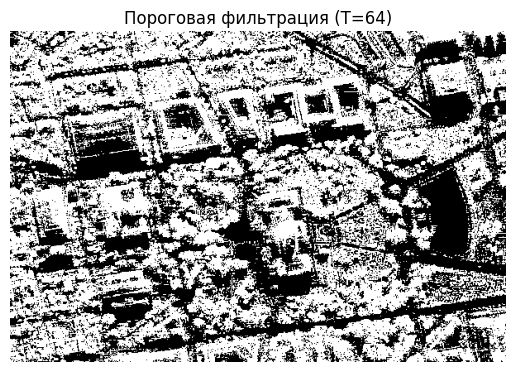

[THRESH] T= 96 -> white=62319 (25.97%), black=177681 (74.03%)


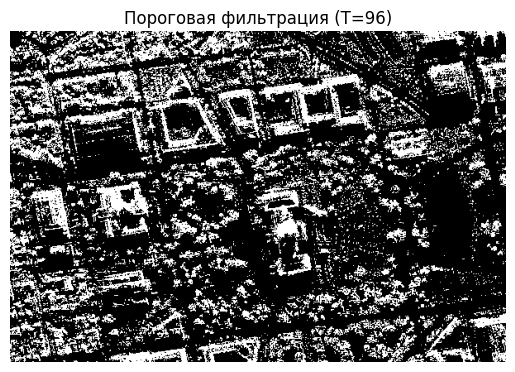

[THRESH] T=128 -> white=24271 (10.11%), black=215729 (89.89%)


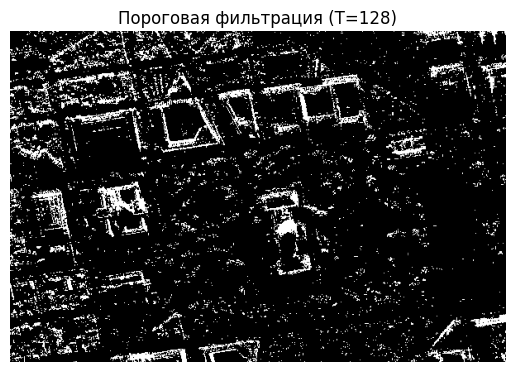

[THRESH] T=160 -> white=10172 (4.24%), black=229828 (95.76%)


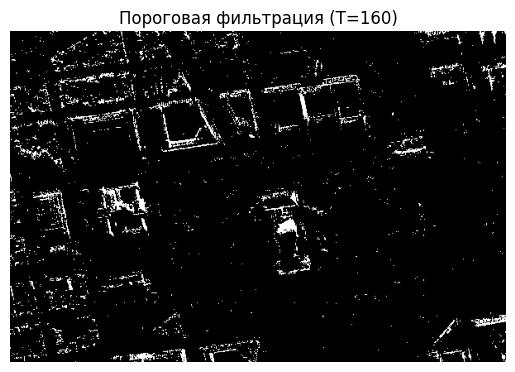

[THRESH] T=192 -> white=4672 (1.95%), black=235328 (98.05%)


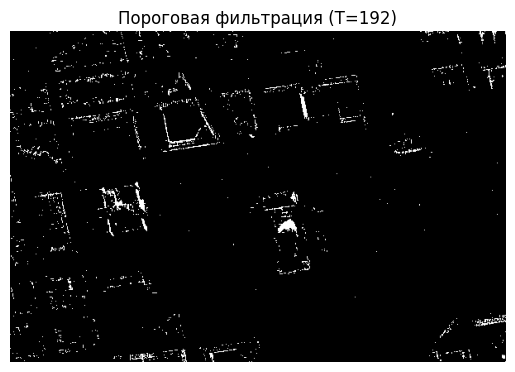

[THRESH] T=224 -> white=2049 (0.85%), black=237951 (99.15%)


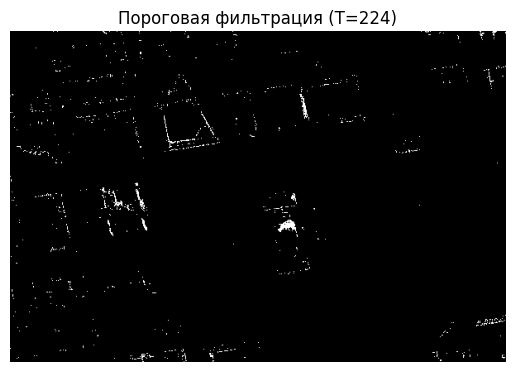

In [15]:
# 6) Пороговая фильтрация при различных параметрах (фикс. пороги + Otsu + Triangle)
# ----------------------------------------------------------------
thresholds = [32, 64, 96, 128, 160, 192, 224]
for t in thresholds:
    _, th = cv2.threshold(gray, t, 255, cv2.THRESH_BINARY)
    white = int((th == 255).sum())
    black = int((th == 0).sum())
    print(f"[THRESH] T={t:3d} -> white={white} ({white/N:.2%}), black={black} ({black/N:.2%})")
    plt.figure(); plt.title(f"Пороговая фильтрация (T={t})")
    plt.imshow(th, cmap='gray', vmin=0, vmax=255); plt.axis('off'); plt.show()